In [4]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

In [5]:
params = {'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [6]:
def create_image(data, cmap='gray', dpi=80, vmin=None, vmax=None, origin=None, norm=None):
    xpixels, ypixels = data.shape[0], data.shape[1]
    figsize = ypixels / dpi, xpixels / dpi
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.imshow(data, cmap=cmap, interpolation='none', vmin=vmin, vmax=vmax, origin=origin, norm=norm)
    plt.axis('off')
    return ax

def plot_image(img, **kwargs):
    img1 = img.copy()
    # downsize image
    binsize = 8
    trim_size_x = img1.shape[1] % binsize
    trim_size_y = img1.shape[0] % binsize
    img1 = img1[:(img1.shape[0]-trim_size_y), :(img1.shape[1]-trim_size_x)]
    # to ignore NAN values, use np.nanmean
    img1 = np.nanmax(np.nanmax(img1.reshape((img1.shape[0]//binsize, binsize, img1.shape[1]//binsize,-1)), axis=3), axis=1)
    create_image(img1, **kwargs)

In [7]:
xys = []
xys.append([3875, 99999])

xys_inspect = []
xys_inspect.append([3875, 2090])

In [14]:
preproc_fn = '/global/cfs/cdirs/desi/spectro/redux/himalayas/preproc/20210708/00097898/preproc-r5-00097898.fits.gz'

fns = [
'pixmask-sm9-r5-20210901.fits.gz',
'pixmask-sm9-r-20201014.fits.gz',
]

In [15]:
img = fitsio.read(preproc_fn)
print(img.shape)

(4128, 4114)


pixmask-sm9-r5-20210901.fits.gz
xy 3875 99999


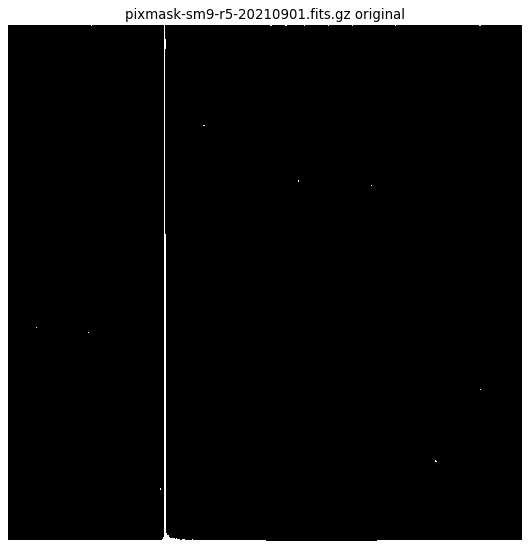

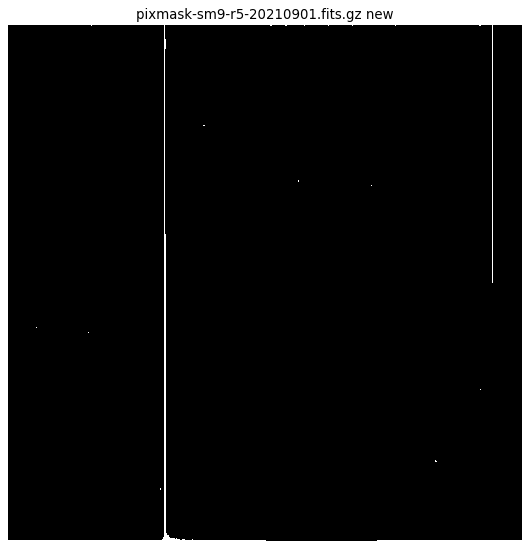

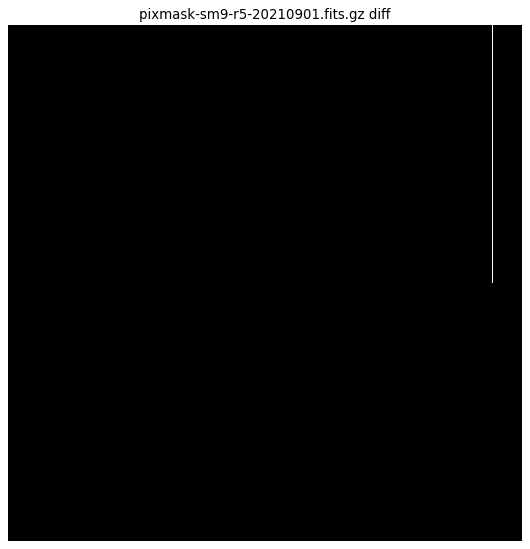

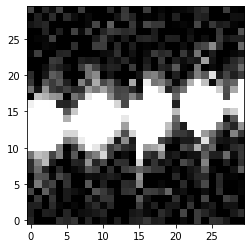

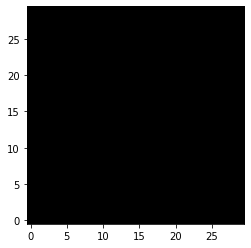

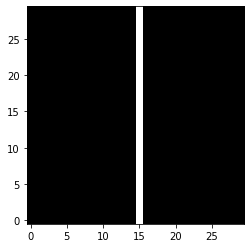

pixmask-sm9-r-20201014.fits.gz
xy 3875 99999


In [19]:
for pm_index in range(len(fns)):
    fn = fns[pm_index]
    print(fn)
    fullfn = os.path.join('/global/cfs/cdirs/desi/users/rongpu/desi_spectro_calib/trunk/ccd', fn)
    # fullfn = os.path.join('/global/cfs/cdirs/desi/spectro/desi_spectro_calib/trunk/ccd', fn)
    pm = fitsio.read(fullfn)
    pm1 = pm.copy()

    if not pm.shape==img.shape:
        raise ValueError

    for index, xy in enumerate(xys):
        x, y = xy
        xi, yi = xys_inspect[index]
        print('xy', x, y)
        if y>=pm1.shape[0]//2:
            mask = pm1[pm1.shape[0]//2:y, x] & 2**0 == 0
            pm1[pm1.shape[0]//2:y, x][mask] += 2**0
        else:
            mask = pm1[y:pm1.shape[0]//2, x] & 2**0 == 0
            pm1[y:pm1.shape[0]//2, x][mask] += 2**0

        if pm_index==0:
            plot_image(pm, vmin=0, vmax=1, origin='lower')
            plt.title(fn+' original')
            plt.show()
            plot_image(pm1, vmin=0, vmax=1, origin='lower')
            plt.title(fn+' new')
            plt.show()
            plot_image(pm!=pm1, vmin=0, vmax=1, origin='lower')
            plt.title(fn+' diff')
            plt.show()

            plt.imshow(img[yi-15:yi+15, xi-15:xi+15], vmin=0, vmax=20, origin='lower', cmap='gray')
            plt.show()
            plt.imshow(pm[yi-15:yi+15, xi-15:xi+15], vmin=0, vmax=1, origin='lower', cmap='gray')
            plt.show()
            plt.imshow(pm1[yi-15:yi+15, xi-15:xi+15], vmin=0, vmax=1, origin='lower', cmap='gray')
            plt.show()

    if np.sum(pm!=pm1)>0:
        fitsio.write(fullfn.replace('.fits.gz', '-new.fits.gz'), pm1, clobber=True)
    else:
        print('No change!')

    # print('################################################################################################\n')
    # print('################################################################################################\n')
    # print('################################################################################################\n')